*Python Machine Learning 3rd Edition* by [Sebastian Raschka](https://sebastianraschka.com) & [Vahid Mirjalili](http://vahidmirjalili.com), Packt Publishing Ltd. 2019

Code Repository: https://github.com/rasbt/python-machine-learning-book-3rd-edition

Code License: [MIT License](https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/LICENSE.txt)

# Chapter 13: Parallelizing Neural Network Training with TensorFlow (Part 1/2)


Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [1]:
%load_ext watermark
%watermark -a "Sebastian Raschka & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,tensorflow

Sebastian Raschka & Vahid Mirjalili 
last updated: 2019-10-26 

numpy 1.16.4
scipy 1.2.1
matplotlib 3.1.0
tensorflow 2.0.0


In [2]:
%matplotlib inline

## TensorFlow and training performance

### Performance challenges

### What is TensorFlow?

### How we will learn TensorFlow

## First steps with TensorFlow

### Installing TensorFlow

In [3]:
#! pip install tensorflow

In [4]:
import tensorflow as tf
print('TensorFlow version:', tf.__version__)
import numpy as np

np.set_printoptions(precision=3)

TensorFlow version: 2.0.0


In [5]:
! python -c 'import tensorflow as tf; print(tf.__version__)'

2.0.0


### Creating tensors in TensorFlow

In [6]:
a = np.array([1, 2, 3], dtype=np.int32)
b = [4, 5, 6]

t_a = tf.convert_to_tensor(a)
t_b = tf.convert_to_tensor(b)

print(t_a)
print(t_b)

tf.Tensor([1 2 3], shape=(3,), dtype=int32)
tf.Tensor([4 5 6], shape=(3,), dtype=int32)


In [7]:
tf.is_tensor(a), tf.is_tensor(t_a)

(False, True)

In [8]:
t_ones = tf.ones((2, 3))

t_ones.shape

TensorShape([2, 3])

In [9]:
t_ones.numpy()

array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)

In [10]:
const_tensor = tf.constant([1.2, 5, np.pi], dtype=tf.float32)

print(const_tensor)

tf.Tensor([1.2   5.    3.142], shape=(3,), dtype=float32)


### Manipulating the data type and shape of a tensor

In [11]:
t_a_new = tf.cast(t_a, tf.int64)

print(t_a_new.dtype)

<dtype: 'int64'>


In [12]:
t = tf.random.uniform(shape=(3, 5))

t_tr = tf.transpose(t)
print(t.shape, ' --> ', t_tr.shape)

(3, 5)  -->  (5, 3)


In [13]:
t = tf.zeros((30,))

t_reshape = tf.reshape(t, shape=(5, 6))

print(t_reshape.shape)

(5, 6)


In [14]:
t = tf.zeros((1, 2, 1, 4, 1))

t_sqz = tf.squeeze(t, axis=(2, 4))

print(t.shape, ' --> ', t_sqz.shape)

(1, 2, 1, 4, 1)  -->  (1, 2, 4)


### Applying mathematical operations to tensors

In [15]:
tf.random.set_seed(1)

t1 = tf.random.uniform(shape=(5, 2), 
                       minval=-1.0,
                       maxval=1.0)

t2 = tf.random.normal(shape=(5, 2), 
                      mean=0.0,
                      stddev=1.0)


In [16]:
t3 = tf.multiply(t1, t2).numpy()
print(t3)

[[-0.27  -0.874]
 [-0.017 -0.175]
 [-0.296 -0.139]
 [-0.727  0.135]
 [-0.401  0.004]]


In [17]:
t4 = tf.math.reduce_mean(t1, axis=0)

print(t4)

tf.Tensor([0.09  0.207], shape=(2,), dtype=float32)


In [18]:
t5 = tf.linalg.matmul(t1, t2, transpose_b=True)

print(t5.numpy())

[[-1.144  1.115 -0.87  -0.321  0.856]
 [ 0.248 -0.191  0.25  -0.064 -0.331]
 [-0.478  0.407 -0.436  0.022  0.527]
 [ 0.525 -0.234  0.741 -0.593 -1.194]
 [-0.099  0.26   0.125 -0.462 -0.396]]


In [19]:
t6 = tf.linalg.matmul(t1, t2, transpose_a=True)

print(t6.numpy())

[[-1.711  0.302]
 [ 0.371 -1.049]]


In [20]:
norm_t1 = tf.norm(t1, ord=2, axis=1).numpy()

print(norm_t1)

[1.046 0.293 0.504 0.96  0.383]


In [21]:
np.sqrt(np.sum(np.square(t1), axis=1))

array([1.046, 0.293, 0.504, 0.96 , 0.383], dtype=float32)

### Split, stack, and concatenate tensors

In [22]:
tf.random.set_seed(1)

t = tf.random.uniform((6,))

print(t.numpy())

t_splits = tf.split(t, 3)

[item.numpy() for item in t_splits]

[0.165 0.901 0.631 0.435 0.292 0.643]


[array([0.165, 0.901], dtype=float32),
 array([0.631, 0.435], dtype=float32),
 array([0.292, 0.643], dtype=float32)]

In [23]:
tf.random.set_seed(1)
t = tf.random.uniform((5,))

print(t.numpy())

t_splits = tf.split(t, [3, 2])

[item.numpy() for item in t_splits]

[0.165 0.901 0.631 0.435 0.292]


[array([0.165, 0.901, 0.631], dtype=float32),
 array([0.435, 0.292], dtype=float32)]

In [24]:
A = tf.ones((3,))
B = tf.zeros((2,))

C = tf.concat([A, B], axis=0)
print(C.numpy())

[1. 1. 1. 0. 0.]


In [25]:
A = tf.ones((3,))
B = tf.zeros((3,))

S = tf.stack([A, B], axis=1)
print(S.numpy())

[[1. 0.]
 [1. 0.]
 [1. 0.]]


## Building input pipelines using tf.data: The TensorFlow Dataset API

### Creating a TensorFlow Dataset from existing tensors 

In [26]:
a = [1.2, 3.4, 7.5, 4.1, 5.0, 1.0]

ds = tf.data.Dataset.from_tensor_slices(a)

print(ds)

<TensorSliceDataset shapes: (), types: tf.float32>


In [27]:
for item in ds:
    print(item)

tf.Tensor(1.2, shape=(), dtype=float32)
tf.Tensor(3.4, shape=(), dtype=float32)
tf.Tensor(7.5, shape=(), dtype=float32)
tf.Tensor(4.1, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [28]:
ds_batch = ds.batch(3)

for i, elem in enumerate(ds_batch, 1):
    print('batch {}:'.format(i), elem.numpy())

batch 1: [1.2 3.4 7.5]
batch 2: [4.1 5.  1. ]


### Combining two tensors into a joint dataset

In [29]:
tf.random.set_seed(1)

t_x = tf.random.uniform([4, 3], dtype=tf.float32)
t_y = tf.range(4)

In [30]:
ds_x = tf.data.Dataset.from_tensor_slices(t_x)
ds_y = tf.data.Dataset.from_tensor_slices(t_y)
    
ds_joint = tf.data.Dataset.zip((ds_x, ds_y))

for example in ds_joint:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.165 0.901 0.631]   y:  0
  x:  [0.435 0.292 0.643]   y:  1
  x:  [0.976 0.435 0.66 ]   y:  2
  x:  [0.605 0.637 0.614]   y:  3


In [31]:
## method 2:
ds_joint = tf.data.Dataset.from_tensor_slices((t_x, t_y))

for example in ds_joint:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.165 0.901 0.631]   y:  0
  x:  [0.435 0.292 0.643]   y:  1
  x:  [0.976 0.435 0.66 ]   y:  2
  x:  [0.605 0.637 0.614]   y:  3


In [32]:
ds_trans = ds_joint.map(lambda x, y: (x*2-1.0, y))

for example in ds_trans:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [-0.67   0.803  0.262]   y:  0
  x:  [-0.131 -0.416  0.285]   y:  1
  x:  [ 0.952 -0.13   0.32 ]   y:  2
  x:  [0.21  0.273 0.229]   y:  3


### Shuffle, batch, and repeat

In [33]:
tf.random.set_seed(1)
ds = ds_joint.shuffle(buffer_size=len(t_x))

for example in ds:
    print('  x: ', example[0].numpy(), 
          '  y: ', example[1].numpy())

  x:  [0.976 0.435 0.66 ]   y:  2
  x:  [0.435 0.292 0.643]   y:  1
  x:  [0.165 0.901 0.631]   y:  0
  x:  [0.605 0.637 0.614]   y:  3


In [34]:
ds = ds_joint.batch(batch_size=3,
                    drop_remainder=False)

batch_x, batch_y = next(iter(ds))

print('Batch-x: \n', batch_x.numpy())

print('Batch-y:   ', batch_y.numpy())

Batch-x: 
 [[0.165 0.901 0.631]
 [0.435 0.292 0.643]
 [0.976 0.435 0.66 ]]
Batch-y:    [0 1 2]


In [35]:
ds = ds_joint.batch(3).repeat(count=2)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())


0 (3, 3) [0 1 2]
1 (1, 3) [3]
2 (3, 3) [0 1 2]
3 (1, 3) [3]


In [36]:
ds = ds_joint.repeat(count=2).batch(3)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())


0 (3, 3) [0 1 2]
1 (3, 3) [3 0 1]
2 (2, 3) [2 3]


In [37]:
tf.random.set_seed(1)

## Order 1: shuffle -> batch -> repeat
ds = ds_joint.shuffle(4).batch(2).repeat(20)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [2 1]
1 (2, 3) [0 3]
2 (2, 3) [0 3]
3 (2, 3) [1 2]
4 (2, 3) [3 0]
5 (2, 3) [1 2]
6 (2, 3) [1 3]
7 (2, 3) [2 0]
8 (2, 3) [1 2]
9 (2, 3) [3 0]
10 (2, 3) [3 0]
11 (2, 3) [2 1]
12 (2, 3) [3 0]
13 (2, 3) [1 2]
14 (2, 3) [3 0]
15 (2, 3) [2 1]
16 (2, 3) [2 3]
17 (2, 3) [0 1]
18 (2, 3) [1 2]
19 (2, 3) [0 3]
20 (2, 3) [0 1]
21 (2, 3) [2 3]
22 (2, 3) [3 2]
23 (2, 3) [0 1]
24 (2, 3) [3 0]
25 (2, 3) [1 2]
26 (2, 3) [1 3]
27 (2, 3) [2 0]
28 (2, 3) [2 1]
29 (2, 3) [0 3]
30 (2, 3) [2 3]
31 (2, 3) [0 1]
32 (2, 3) [3 1]
33 (2, 3) [2 0]
34 (2, 3) [3 2]
35 (2, 3) [1 0]
36 (2, 3) [3 0]
37 (2, 3) [2 1]
38 (2, 3) [0 2]
39 (2, 3) [3 1]


In [38]:
tf.random.set_seed(1)

## Order 2: batch -> shuffle -> repeat
ds = ds_joint.batch(2).shuffle(4).repeat(20)

for i,(batch_x, batch_y) in enumerate(ds):
    print(i, batch_x.shape, batch_y.numpy())

0 (2, 3) [0 1]
1 (2, 3) [2 3]
2 (2, 3) [0 1]
3 (2, 3) [2 3]
4 (2, 3) [2 3]
5 (2, 3) [0 1]
6 (2, 3) [2 3]
7 (2, 3) [0 1]
8 (2, 3) [2 3]
9 (2, 3) [0 1]
10 (2, 3) [2 3]
11 (2, 3) [0 1]
12 (2, 3) [2 3]
13 (2, 3) [0 1]
14 (2, 3) [2 3]
15 (2, 3) [0 1]
16 (2, 3) [0 1]
17 (2, 3) [2 3]
18 (2, 3) [2 3]
19 (2, 3) [0 1]
20 (2, 3) [0 1]
21 (2, 3) [2 3]
22 (2, 3) [2 3]
23 (2, 3) [0 1]
24 (2, 3) [2 3]
25 (2, 3) [0 1]
26 (2, 3) [2 3]
27 (2, 3) [0 1]
28 (2, 3) [0 1]
29 (2, 3) [2 3]
30 (2, 3) [0 1]
31 (2, 3) [2 3]
32 (2, 3) [2 3]
33 (2, 3) [0 1]
34 (2, 3) [2 3]
35 (2, 3) [0 1]
36 (2, 3) [2 3]
37 (2, 3) [0 1]
38 (2, 3) [0 1]
39 (2, 3) [2 3]


### Creating a dataset from files on your local storage disk

In [39]:
import pathlib

imgdir_path = pathlib.Path('images')

file_list = [str(path) for path in imgdir_path.glob('*.jpg')]

print(file_list)

['images/cat-03.jpg', 'images/cat-01.jpg', 'images/cat-02.jpg', 'images/dog-02.jpg', 'images/dog-01.jpg', 'images/dog-03.jpg']


Image shape:  (900, 742, 3)
Image shape:  (900, 1200, 3)
Image shape:  (900, 1200, 3)
Image shape:  (800, 1200, 3)
Image shape:  (800, 1200, 3)
Image shape:  (900, 1200, 3)


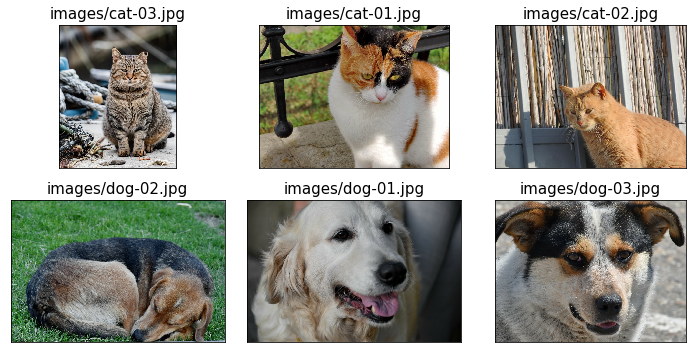

In [40]:
import tensorflow as tf
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10, 5))
for i,file in enumerate(file_list):
    img_raw = tf.io.read_file(file)
    img = tf.image.decode_image(img_raw)
    print('Image shape: ', img.shape)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(file, size=15)
    
# plt.savefig('ch13-catdot-examples.pdf')
plt.tight_layout()
plt.show()

In [41]:
labels = [1 if 'dog' in file else 0
          for file in file_list]
print(labels)

[0, 0, 0, 1, 1, 1]


In [42]:
ds_files_labels = tf.data.Dataset.from_tensor_slices(
    (file_list, labels))

for item in ds_files_labels:
    print(item[0].numpy(), item[1].numpy())

b'images/cat-03.jpg' 0
b'images/cat-01.jpg' 0
b'images/cat-02.jpg' 0
b'images/dog-02.jpg' 1
b'images/dog-01.jpg' 1
b'images/dog-03.jpg' 1


(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 0
(80, 120, 3) 1
(80, 120, 3) 1
(80, 120, 3) 1


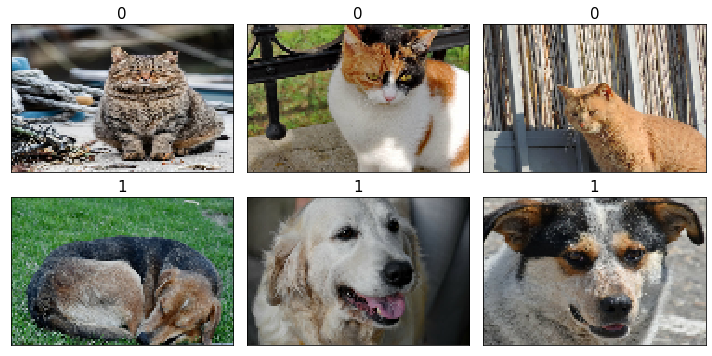

In [43]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_height, img_width])
    image /= 255.0

    return image, label

img_width, img_height = 120, 80

ds_images_labels = ds_files_labels.map(load_and_preprocess)

fig = plt.figure(figsize=(10, 5))
for i,example in enumerate(ds_images_labels):
    print(example[0].shape, example[1].numpy())
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title('{}'.format(example[1].numpy()), 
                 size=15)
    
plt.tight_layout()
#plt.savefig('ch13-catdog-dataset.pdf')
plt.show()

### Fetching available datasets from the tensorflow_datasets library

In [44]:
! pip install tensorflow-datasets

In [45]:
import tensorflow_datasets as tfds

print(len(tfds.list_builders()))
print(tfds.list_builders()[:5])

122
['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small']


In [46]:
## Run this to see the full list:
tfds.list_builders()

['abstract_reasoning',
 'aeslc',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'clevr',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco2014',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'diabetic_retinopathy_detection',
 'downsampled_imagenet',
 'dsprites',
 'dtd',
 'dummy_dataset_shared_generator',
 'dummy_mnist',
 'emnist',
 'eurosat',
 'fashion_mnist',
 'flores',
 'food101',
 'gap',
 'gigaword',
 'glue',
 'groove',
 'higgs',
 'horses_or_humans',
 'image_label_folder',
 'imagenet2012',
 'imagenet2012_corrupted',
 'imagenet_resized',
 'imdb_reviews',
 'iris',
 '

Fetching CelebA dataset

In [47]:
celeba_bldr = tfds.builder('celeb_a')

print(celeba_bldr.info.features)
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features.keys())
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features['image'])
print('\n', 30*"=", '\n')
print(celeba_bldr.info.features['attributes'].keys())
print('\n', 30*"=", '\n')
print(celeba_bldr.info.citation)

FeaturesDict({
    'attributes': FeaturesDict({
        '5_o_Clock_Shadow': Tensor(shape=(), dtype=tf.bool),
        'Arched_Eyebrows': Tensor(shape=(), dtype=tf.bool),
        'Attractive': Tensor(shape=(), dtype=tf.bool),
        'Bags_Under_Eyes': Tensor(shape=(), dtype=tf.bool),
        'Bald': Tensor(shape=(), dtype=tf.bool),
        'Bangs': Tensor(shape=(), dtype=tf.bool),
        'Big_Lips': Tensor(shape=(), dtype=tf.bool),
        'Big_Nose': Tensor(shape=(), dtype=tf.bool),
        'Black_Hair': Tensor(shape=(), dtype=tf.bool),
        'Blond_Hair': Tensor(shape=(), dtype=tf.bool),
        'Blurry': Tensor(shape=(), dtype=tf.bool),
        'Brown_Hair': Tensor(shape=(), dtype=tf.bool),
        'Bushy_Eyebrows': Tensor(shape=(), dtype=tf.bool),
        'Chubby': Tensor(shape=(), dtype=tf.bool),
        'Double_Chin': Tensor(shape=(), dtype=tf.bool),
        'Eyeglasses': Tensor(shape=(), dtype=tf.bool),
        'Goatee': Tensor(shape=(), dtype=tf.bool),
        'Gray_Hair': Te

In [48]:
# Download the data, prepare it, and write it to disk
celeba_bldr.download_and_prepare()

W1026 11:46:06.001411 140500853634880 deprecation.py:323] From /home/raschka/miniconda3/lib/python3.7/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset celeb_a downloaded and prepared to /home/raschka/tensorflow_datasets/celeb_a/0.3.0. Subsequent calls will reuse this data.


In [49]:
# Load data from disk as tf.data.Datasets
datasets = celeba_bldr.as_dataset()

datasets.keys()

dict_keys(['test', 'train', 'validation'])

In [50]:
#import tensorflow as tf
ds_train = datasets['train']
assert isinstance(ds_train, tf.data.Dataset)

example = next(iter(ds_train))
print(type(example))
print(example.keys())

<class 'dict'>
dict_keys(['attributes', 'image', 'landmarks'])


In [51]:
ds_train = ds_train.map(lambda item: 
     (item['image'], tf.cast(item['attributes']['Male'], tf.int32)))

In [52]:
ds_train = ds_train.batch(18)
images, labels = next(iter(ds_train))

print(images.shape, labels)

(18, 218, 178, 3) tf.Tensor([1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0], shape=(18,), dtype=int32)


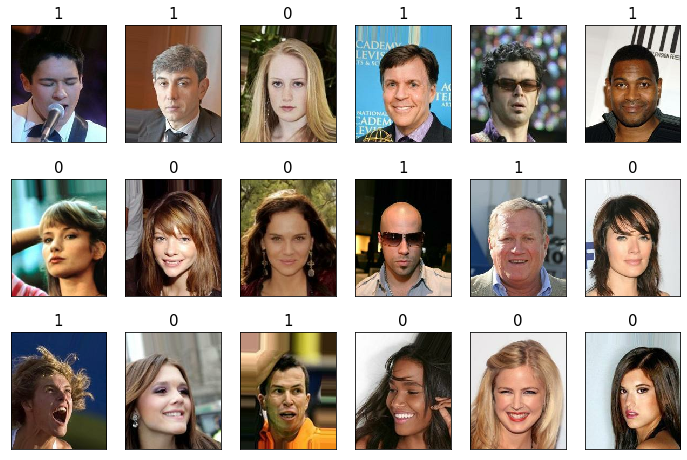

In [53]:
fig = plt.figure(figsize=(12, 8))
for i,(image,label) in enumerate(zip(images, labels)):
    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image)
    ax.set_title('{}'.format(label), size=15)
    
plt.show()

Alternative ways for loading a dataset

In [54]:
mnist, mnist_info = tfds.load('mnist', with_info=True)

print(mnist_info)

print(mnist.keys())

/home/raschka/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/raschka/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/raschka/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/home/raschka/miniconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:847

Dataset mnist downloaded and prepared to /home/raschka/tensorflow_datasets/mnist/1.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['https://storage.googleapis.com/cvdf-datasets/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

dict_keys(['test', 'train'])


(10, 28, 28, 1) tf.Tensor([3 4 7 1 9 0 8 8 9 7], shape=(10,), dtype=int64)


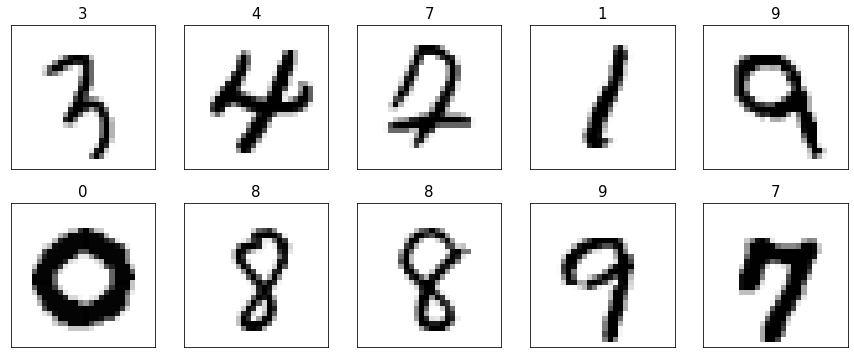

In [55]:
ds_train = mnist['train']

assert isinstance(ds_train, tf.data.Dataset)

ds_train = ds_train.map(lambda item: 
     (item['image'], item['label']))

ds_train = ds_train.batch(10)
batch = next(iter(ds_train))
print(batch[0].shape, batch[1])

fig = plt.figure(figsize=(15, 6))
for i,(image,label) in enumerate(zip(batch[0], batch[1])):
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(image[:, :, 0], cmap='gray_r')
    ax.set_title('{}'.format(label), size=15)

<br>
<br>
<br>

---

Readers may ignore the next cell.

In [56]:
! python ../.convert_notebook_to_script.py --input ch13_part1.ipynb --output ch13_part1.py

[NbConvertApp] Converting notebook ch13_part1.ipynb to script
[NbConvertApp] Writing 9946 bytes to ch13_part1.py
